# Week 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import edhec_risk_kit as erk

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

# Risk insurance strategies 

Recent market crises have highlighted the benefits of risk-controlled strategies that allow investors to benefit from **downside risk protection**. 

Here, we describe a set of risk insurance strategies, starting with **Constant Proportion Portfolio Insurance (CPPI)** strategies, 
and moving on to more sophisticated strategies that aim at achieving the highest possible upside potential while imposing 
stringent limits to portfolio drawdown.

Then, we talk about calibration and implementation challenges and introduce **Monte-Carlo simulations techniques**, 
which are required for the proper backtesting of insurance strategies.

## The limits of Portfolio diversification
Things that diversification **is effective** at: 

1. diversification is an effective way to increase the reward per unit of risk;
2. diversification is an effective way to decrease **idiosyncratic or specific** risk: in fact, it allows investors to reduce specific risk within their portfolios, which is how they can achieve a high reward per unit of risk.

Things that diversification **is not effective** at: 

1. diversification **is not** an effective way to decrease the **systemic risk**: basically, if the entire market collapses, it does not really matter how much your portfolio is diversified since correlation levels tend to increase and diversification benefits tend to disappear.
 
In the following, we want to highlight the last point, i.e., we want to show that in case of huge financial crisis the diversification of a portfolio is not a guarantee of less risk.

Let us load the Industry following datasets:

In [5]:
ind_rets   = erk.get_ind_returns()
ind_nfirms = erk.get_ind_nfirms()
ind_size   = erk.get_ind_size() 

In [6]:
ind_rets.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08-01,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09-01,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386


The dataframe **ind_rets** contains the returns (from 1926-2018) of $30$ portfolios including different industry sectors such as food, beer, smoke, etc. 

Such portofolios are constructed by using the weights equal to the corresponding market capitalizations. 
The **market capitalization** of a company is the **total value of the company** defined as 
the number of shares outstanding of that company multiplied by the share price 
(for example, there are 100,000 shares of company "A", and the share price is 20.3, hence the market cap of company "A" is 2,030,000).


For example, the columns **Food** contains the returns of a portfolio consisting of all the companies in the food sectors for each month from 1926 to 2019. The portfolio has been constructed by weighting each company according to its market capitalization.

Now, the number of firms composing each single sector are stored in **ind_nfirms**:

In [7]:
ind_nfirms.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


that is, in 1926-07, there were 43 (food) companies in the Food portfolio, 3 (beer) companies in the Beer portfolio, etc.

Finally, the datframe **ind_size** contains the **average size** of the companies composing the portfolio:

In [8]:
ind_size.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08-01,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09-01,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21


that is, the average size of the 43 Food companies in 1926-07 was 35.98, the average size of the 3 Beer companies was 7.12, ans so on (it does not matter the unit). 
By **average size** we mean the **average of the market capitalizations** of the 43 food companies, of the 3 Beer companies, etc.

### Constructing the index

The first thing to do is to get the **market capitalization of each industry sector.**
This is simply given by the number of firms times their average size:

In [9]:
ind_mkt_cap = ind_nfirms * ind_size
ind_mkt_cap.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,1547.14,21.36,955.52,184.87,24.04,178.16,220.32,178.64,979.03,80.34,...,1751.80,40.80,396.90,212.10,4951.34,2.38,1539.45,64.92,225.96,97.00
1926-08-01,1552.30,20.25,967.52,190.19,26.66,177.04,237.96,180.60,1056.21,80.60,...,1766.35,44.25,404.18,227.16,5031.26,1.80,1536.81,66.00,226.56,102.04
1926-09-01,1591.00,25.74,1024.48,191.10,29.34,169.44,231.48,187.11,1114.01,87.23,...,1804.80,45.15,417.27,220.92,5255.48,1.90,1521.63,65.64,236.04,108.84


Now, we want to get the **total market capitalization**, in order to get the fraction of the 
total market capitalization which is in each industry. 

The total market capitalization
is a single time series **representing the total value of the market at each month**. 
This can be obtained by summing each market capitalization of each sector every month, i.e., 
by horizontally summing the **ind_mkt_cap**:

In [122]:
# total market capitalization: 
total_mkt_cap = ind_mkt_cap.sum(axis=1)
total_mkt_cap.head(3)

1926-07-01    26657.94
1926-08-01    27436.34
1926-09-01    28060.41
dtype: float64

and now, we can divide each single market cap by the total market cap:

In [123]:
ind_cap_weights = ind_mkt_cap.divide(total_mkt_cap, axis=0)
ind_cap_weights.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,0.058037,0.000801,0.035844,0.006935,0.000902,0.006683,0.008265,0.006701,0.036726,0.003014,...,0.065714,0.001531,0.014889,0.007956,0.185736,0.000089,0.057748,0.002435,0.008476,0.003639
1926-08-01,0.056578,0.000738,0.035264,0.006932,0.000972,0.006453,0.008673,0.006583,0.038497,0.002938,...,0.064380,0.001613,0.014732,0.008280,0.183379,0.000066,0.056014,0.002406,0.008258,0.003719
1926-09-01,0.056699,0.000917,0.036510,0.006810,0.001046,0.006038,0.008249,0.006668,0.039700,0.003109,...,0.064318,0.001609,0.014870,0.007873,0.187292,0.000068,0.054227,0.002339,0.008412,0.003879


This means that, for example, in 1926-07 the total market capitalization was $26657.94$ and that 
the Food companies (in the portfolio for this month) represented all together about the $5.8\%$, 
the Beer companies (in the portfolio for this month) represented all together about the $0.08\%$, and so on. 

Let us visualize these things:

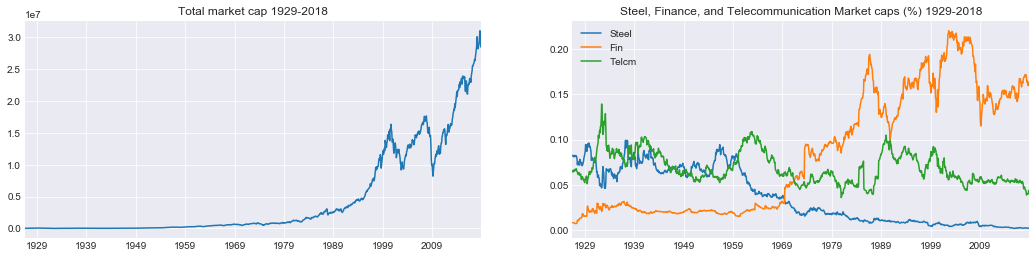

In [11]:
fig, ax = plt.subplots(1,2,figsize=(18,4)) 
total_mkt_cap.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap 1929-2018")

ind_cap_weights[["Steel","Fin","Telcm"]].plot(grid=True, ax=ax[1])
ax[1].set_title("Steel, Finance, and Telecommunication Market caps (%) 1929-2018")
plt.show()

In the plot on the left we have the total market cap from 1929 to 2018. On the right, we have the Steel, Finance, and Telecommunication Market 
caps 1929-2018 as a percentage of the total market cap. 

For example, notice that while the Finance sector was around the $3\%$ of the total market cap in 1929, in 2018 it was more than $15\%$. 
On the other hand, the Stell sector was around the $9\%$ in 1929 until decreasing to the $0.2\%$ in 2018.

Now, let us find the **total maket return**, i.e., the return time series from the total market. 
This is simply going to be the sum of the weights of each sector times their corresponding monthly returns.

Once we have the total market return series, we can **compound** it and obtain 
the **total market index** (what we called the **wealth** in week 1):

In [124]:
total_market_return = (ind_cap_weights * ind_rets).sum(axis=1)

# suppose to have invested a capital of 1000$ in the market
capital = 1000
total_market_index = capital * (1 + total_market_return).cumprod()

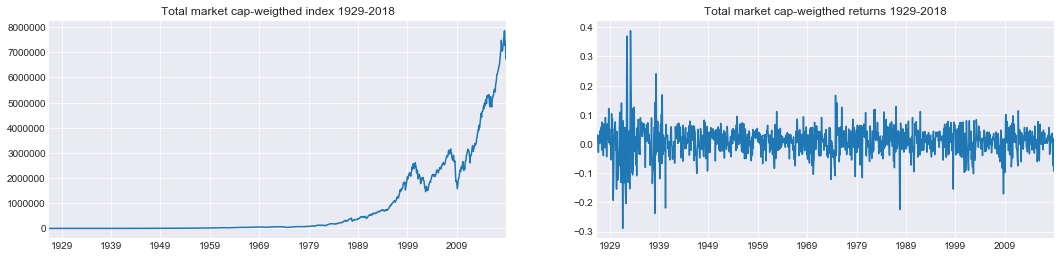

In [125]:
fig, ax = plt.subplots(1,2,figsize=(18,4)) 

total_market_index.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap-weigthed index 1929-2018")

total_market_return.plot(grid=True, ax=ax[1])
ax[1].set_title("Total market cap-weigthed returns 1929-2018")

plt.show()

Notice that the plot of the (cap-weigthed) index is, of course, the same (but different in values) as the plot of the total market capitalization.

Next, we what to see **how returns are relatd to market correlations**.

### Rolling returns

Let us plot the total market index, say from 1990, and plot together some moving average (MA) series corresponding to 60, 36, and 12 months (i.e, 5, 3, and 1 years), respectively, just to look at how the **.rolling** method works.

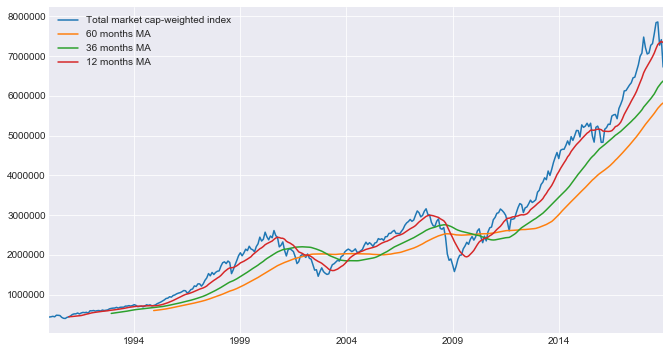

In [127]:
total_market_index["1990":].plot(grid=True, figsize=(11,6), label="Total market cap-weighted index")

total_market_index["1990":].rolling(window=60).mean().plot(grid=True, figsize=(11,6), label="60 months MA") # 5 years MA
total_market_index["1990":].rolling(window=36).mean().plot(grid=True, figsize=(11,6), label="36 months MA") # 3 years MA
total_market_index["1990":].rolling(window=12).mean().plot(grid=True, figsize=(11,6), label="12 months MA") # 1 year MA

plt.legend()
plt.show()

Ok. Now compute the **trailing 36 months compound returns** of total_market_return**. 
That is, we take the total market return series and open the rolling windows for 36 months. Then, for each rolling window (by using **.aggregate**) we compound the returns: 

In [131]:
tmi_trail_36_rets = total_market_return.rolling(window=36).aggregate( erk.annualize_rets, periods_per_year=12 )

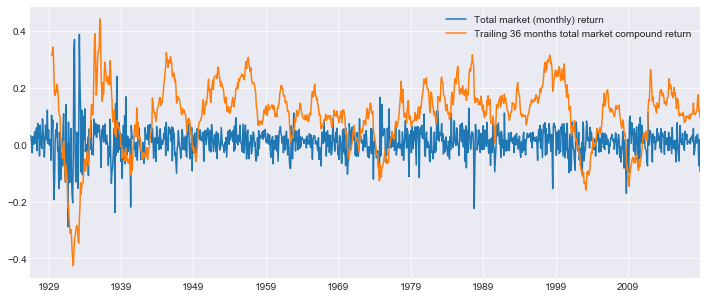

In [133]:
# Plot them
total_market_return.plot(grid=True, figsize=(12,5), label="Total market (monthly) return")
tmi_trail_36_rets.plot(grid=True, figsize=(12,5), label="Trailing 36 months total market compound return")

plt.legend()
plt.show()

### Rolling correlations: multi-indices and groupby

Let us now compute the **rolling** correlations across industries, in the same way as we have computed the trailing 36 months compound returns. We use the **.corr()** method which computes the **pairwise correlation** between columns of the dataframe.

In [79]:
rets_trail_36_corr = ind_rets.rolling(window=36).corr()
rets_trail_36_corr.index.names = ["date","industry"]
rets_trail_36_corr.tail()

Food      Beer     Smoke     Games     Books  \
date       industry                                                     
2018-12-01 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362   
           Rtail     0.517856  0.406107  0.030283  0.676464  0.636320   
           Meals     0.370187  0.385483  0.122007  0.301516  0.520649   
           Fin       0.298823  0.192706  0.027593  0.480276  0.694812   
           Other     0.436952  0.376565  0.224010  0.331829  0.558072   

                        Hshld     Clths      Hlth     Chems     Txtls  ...  \
date       industry                                                    ...   
2018-12-01 Whlsl     0.419280  0.570071  0.739764  0.785796  0.634197  ...   
           Rtail     0.358336  0.676598  0.714933  0.626034  0.634202  ...   
           Meals     0.308216  0.302176  0.416193  0.520023  0.491726  ...   
           Fin       0.162690  0.425899  0.658468  0.760151  0.577090  ...   
           Other     0.390610  0.467099  0.645035  0.712511  0.520953  ...   

                        Telcm     Servs     BusEq     Paper     Trans  \
date       industry                                                     
2018-12-01 Whlsl     0.648092  0.567395  0.543362  0.764252  0.829185   
           Rtail     0.562238  0.762616  0.628246  0.656510  0.630615   
           Meals     0.406184  0.444629  0.399438  0.627113  0.663358   
           Fin       0.420863  0.585418  0.517947  0.670936  0.760730   
           Other     0.607868  0.460322  0.434487  0.773798  0.756961   

                        Whlsl     Rtail     Meals       Fin     Other  
date       industry                                                    
2018-12-01 Whlsl     1.000000  0.744842  0.643879  0.746480  0.767652  
           Rtail     0.744842  1.000000  0.616947  0.611883  0.619918  
           Meals     0.643879  0.616947  1.000000  0.502563  0.605226  
           Fin       0.746480  0.611883  0.502563  1.000000  0.734837  
           Other     0.767652  0.619918  0.605226  0.734837  1.000000  

[5 rows x 30 columns]

The dataframe above is a **time series of correlation matrices**. 
That is, each matrix represents the trailing $36$ months **correlation matrix** of compund returns of the industries for each available data. 
That is, is we look at **rets_trail_36_corr.tail(30)** we would see the (trailing 36 months) correlation matrix of industries during the last available month, i.e., 2018-12,. 
If we look at **rets_trail_36_corr.tail(60)** we would see the same correlation matrix for 2018-12 and the (trailing 36 months) correlation matrix of 2018-11, etc.

In the example above, we see that during 2018-12, the  (trailing 36 months) correlation between Whlsl and Food was about 0.47, 
the (trailing 36 months) correlation betwenn Rtail and Smoke was about 0.03, and so on. 

Notice that due to the structure of such a dataframe, we have a **double index**: per each index date, we have the set of index industries. 

Next, we want to the see **averages of all these correlation matrices** for each date. To do that, we first get single correlation matrices  using **groupby by date** and the we take the average of them. The result is pandas Series:

In [134]:
ind_trail_36_corr = rets_trail_36_corr.groupby(level="date").apply(lambda corrmat: corrmat.values.mean())

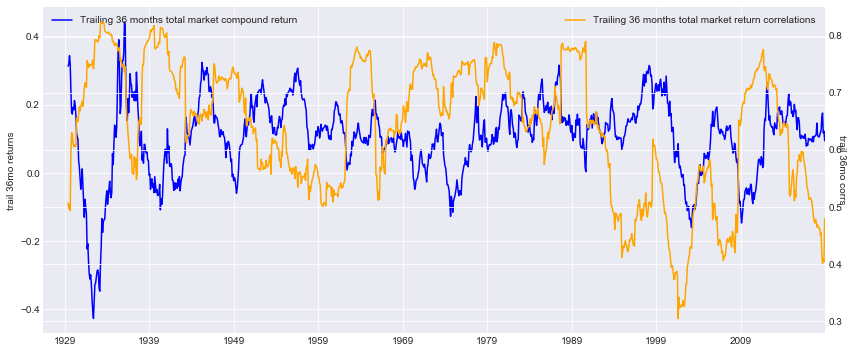

In [135]:
fig, ax1 = plt.subplots(1,1,figsize=(14,6))

tmi_trail_36_rets.plot(ax=ax1, color="blue", grid=True, label="Trailing 36 months total market compound return")
ax2 = ax1.twinx()
ind_trail_36_corr.plot(ax=ax2, color="orange", grid=True, label="Trailing 36 months total market return correlations")

ax1.set_ylabel('trail 36mo returns')
ax2.set_ylabel('trail 36mo corrs',rotation=-90)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

For example, during the 1929 crisis, we see that when (trailing 36 months) returns of the overall market falls, the average correlation of industries of the market increases, and that when returns recovers, then correlations falls. 

This can be also seen in the Lehman Brother crisis. When in 2007 returns started to fall then correlations increased.

When this happens, we simply realize **the limits of diversification**. Returns from the entire market falls means that, on average, all industries in the market are suffering losses, i.e., they correlation increases, and it does not really matter how diversified the portfolio is. **Diversification may not help you when market crashes**.

However, **this is not always so: look at the dot com crisis of from 1999.** Returns and correlations follow the same trend, showing that in this case diversification could help to stop losses$\dots$

In general:

In [136]:
tmi_trail_36_rets.corr(ind_trail_36_corr)

-0.2801006506288413

this is, the correlation between the series of (trailing 36 months) compound returns and the series of average correlations 
across industries **is negative**.

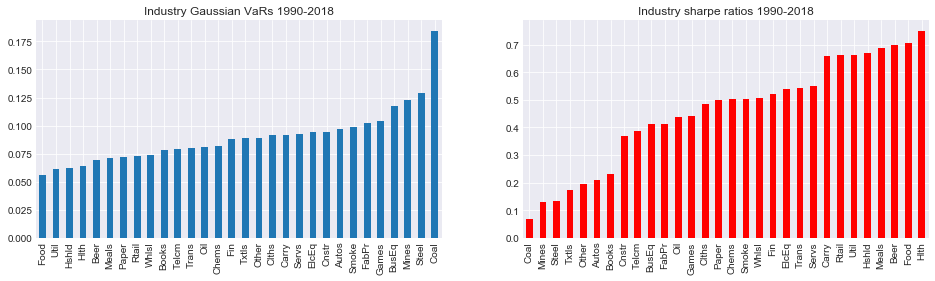

In [16]:
fig, ax = plt.subplots(figsize=(20,4), nrows=1, ncols=2)
erk.var_gaussian(ind_rets["1990":"2018"], cf=True).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[0], title="Industry Gaussian VaRs 1990-2018")
erk.sharpe_ratio(ind_rets["1990":"2018"], 0.0, 12).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[1], title="Industry sharpe ratios 1990-2018", color="r")
plt.show()